# Create a PDF of the Data Quality Report for Data Desginer

# 🎛️ Import things

In [ ]:
import os
from pprint import pprint

from datasets import load_dataset

from navigator_helpers.llms.llm_suite import GretelLLMSuite
from navigator_helpers.tasks.evaluation.evaluation import (
    BaseEvaluationTaskSuite,
    VisualizationTaskSuite
)

# set environment variable 'GRETEL_PROD_API_KEY' from https://console.gretel.ai/users/me/key
gretel_prod_api_key = input("Enter your Gretel API key from https://console.gretel.ai/users/me/key: ")
os.environ['GRETEL_PROD_API_KEY'] = gretel_prod_api_key

# 🔢 Choose Dataset for Evaluation

In [ ]:
# Set the number of samples to load from the dataset for testing
# Set to None to use the full dataset
NUM_SAMPLES = 1000

datasets_dict = {
    "synthetic_text_to_sql": {
        "dataset_kwargs": {
            "path": "gretelai/synthetic_text_to_sql",
            "split": "train"
        },
        "code_lang": "sql",
        "eval_kwargs":{
            "instruction_col_name": "sql_prompt",
            "code_col_name": "sql",
            "context_col_name": "sql_context"
        }
    },
    "gsm8k": {
        "dataset_kwargs": {
            "path": "openai/gsm8k",
            "name": "main",
            "split": "train"
        },
        "eval_kwargs": {
            "instruction_col_name": "question",
            "code_col_name": "answer",
        }
    },
    "synthetic_gsm8k": {
        "dataset_kwargs": {
            "path": "gretelai/synthetic-gsm8k-reflection-405b",
            "split": "train"
        },
        "eval_kwargs": {
            "instruction_col_name": "question",
            "code_col_name": "answer",
        }
    },
    "xlcost_text_to_code": {
        "dataset_kwargs": {
            "path": "codeparrot/xlcost-text-to-code",
            "split": "train"
        },
        "code_lang": "python",
        "eval_kwargs": {
            "instruction_col_name": "text",
            "code_col_name": "code",
        }
    },
}

# Prompt user to select a dataset
print("Available datasets:")
for key in datasets_dict.keys():
    print(f" - {key}")

selected_dataset = input("\nEnter the name of the dataset to load: ").strip()

# Load the selected dataset
if selected_dataset in datasets_dict:
    dataset_dict = datasets_dict[selected_dataset]
    eval_kwargs = dataset_dict["eval_kwargs"]
    code_lang = dataset_dict["code_lang"] if "code_lang" in dataset_dict.keys() else None
    dataset = load_dataset(**dataset_dict["dataset_kwargs"])

    # Optionally, select a subset if NUM_SAMPLES is specified
    if NUM_SAMPLES is not None and NUM_SAMPLES < len(dataset):
        dataset = dataset.select(range(NUM_SAMPLES))
    
    dataset_df = dataset.to_pandas()
    
    print(f"Loaded dataset '{selected_dataset}' successfully!")
else:
    print("Error: Dataset not found. Please enter a valid dataset name.")

In [63]:
# tmp
import pandas as pd
# dataset_df = pd.read_json('/mnt/foundation-shared/nina_xu_gretel_ai/datasets/text_to_python_v1.json')
dataset_df = pd.read_csv("/mnt/foundation-shared/nina_xu_gretel_ai/datasets/judge_with_llm_results.csv")
dataset_df.head(1)

,id,domain,topic,complexity,prompt,dependency_list,code,code_is_valid,code_score,code_severity,code_messages,llm_judge_scores
0,232,Financial Services,Loan Processing,"Beginner: Basic syntax, data types, and contro...","Write a Python function named ""calculate_month...","['numpy', 'pandas', 'tensorflow', 'matplotlib'...",import numpy as np\n\ndef calculate_monthly_pa...,True,8.333333,warning,"[{'symbol': 'unused-import', 'msg': 'Unused nu...","{\n ""relevance"": {""score"": 4, ""reasoning"": ..."


In [86]:
results = {'results': {'row_uniqueness': {'percent_unique': 100.0,
   'percent_semantically_unique': 100.0,
   'non_unique_ids': [],
   'non_semantically_unique_ids': []},
  'feature_cardinality': {'id': 10,
   'domain': 5,
   'topic': 10,
   'complexity': 4,
   'prompt': 10,
   'dependency_list': 3,
   'code': 10,
   'code_is_valid': 2,
   'code_score': 9,
   'code_severity': 3,
   'code_messages': 9,
   'llm_judge_scores': 10},
  'feature_distribution': {'distribution': {'id': None,
    'domain': {'avg_length': 19.8,
     'std_length': 1.9321835661585918,
     'avg_word_count': 2.1,
     'word_count_histogram': ([0, 0, 0, 1, 0, 0, 7, 0, 0, 2],
      [0.0,
       0.3,
       0.6,
       0.8999999999999999,
       1.2,
       1.5,
       1.7999999999999998,
       2.1,
       2.4,
       2.6999999999999997,
       3.0])},
    'topic': {'avg_length': 20.4,
     'std_length': 4.033195589934446,
     'avg_word_count': 2.2,
     'word_count_histogram': ([0, 0, 0, 0, 0, 0, 8, 0, 0, 2],
      [0.0,
       0.3,
       0.6,
       0.8999999999999999,
       1.2,
       1.5,
       1.7999999999999998,
       2.1,
       2.4,
       2.6999999999999997,
       3.0])},
    'complexity': {'avg_length': 57.9,
     'std_length': 3.8427420765212266,
     'avg_word_count': 6.6,
     'word_count_histogram': ([0, 0, 0, 0, 0, 0, 0, 7, 0, 3],
      [0.0,
       0.8,
       1.6,
       2.4000000000000004,
       3.2,
       4.0,
       4.800000000000001,
       5.6000000000000005,
       6.4,
       7.2,
       8.0])},
    'prompt': {'avg_length': 1169.1,
     'std_length': 417.28126672012917,
     'avg_word_count': 174.1,
     'word_count_histogram': ([0, 0, 0, 6, 2, 1, 0, 0, 0, 1],
      [0.0,
       38.3,
       76.6,
       114.89999999999999,
       153.2,
       191.5,
       229.79999999999998,
       268.09999999999997,
       306.4,
       344.7,
       383.0])},
    'dependency_list': {"['matplotlib', 'numpy', 'pandas', 'scikit-learn', 'tensorflow']": 5,
     "['matplotlib', 'numpy', 'pandas', 'scikit-learn', 'seaborn']": 4,
     "['matplotlib', 'numpy', 'pandas', 'seaborn', 'sklearn']": 1},
    'code': {'avg_length': 1211.5,
     'std_length': 744.9386626502286,
     'avg_word_count': 119.6,
     'word_count_histogram': ([1, 1, 1, 2, 1, 2, 0, 1, 0, 1],
      [0.0,
       27.0,
       54.0,
       81.0,
       108.0,
       135.0,
       162.0,
       189.0,
       216.0,
       243.0,
       270.0])},
    'code_is_valid': {True: 8, False: 2},
    'code_score': {10.0: 2,
     7.5: 1,
     8.333333333333334: 1,
     8.88888888888889: 1,
     5.9259259259259265: 1,
     7.948717948717949: 1,
     6.938775510204081: 1,
     8.5: 1,
     9.0: 1},
    'code_severity': {'warning': 6, 'none': 2, 'error': 2},
    'code_messages': {'avg_length': 376.8,
     'std_length': 340.17211329952767,
     'avg_word_count': 38.1,
     'word_count_histogram': ([2, 1, 1, 3, 2, 0, 0, 0, 0, 1],
      [0.0,
       11.8,
       23.6,
       35.400000000000006,
       47.2,
       59.0,
       70.80000000000001,
       82.60000000000001,
       94.4,
       106.2,
       118.0])},
    'llm_judge_scores': {'avg_length': 1067.8,
     'std_length': 186.9859174733042,
     'avg_word_count': 141.3,
     'word_count_histogram': ([0, 0, 0, 0, 0, 1, 2, 0, 5, 2],
      [0.0,
       17.6,
       35.2,
       52.800000000000004,
       70.4,
       88.0,
       105.60000000000001,
       123.20000000000002,
       140.8,
       158.4,
       176.0])}},
   'score': {'id': None,
    'domain': {'text_diversity_index': 0.47491147384936305},
    'topic': {'text_diversity_index': 0.6837722339831621},
    'complexity': {'text_diversity_index': 0.4545170585682964},
    'prompt': {'text_diversity_index': 0.4155945214318475},
    'dependency_list': {'gini-simpson_index': 0.58},
    'code': {'text_diversity_index': 0.6259925995996702},
    'code_is_valid': {'gini-simpson_index': 0.32},
    'code_score': {'gini-simpson_index': 0.88},
    'code_severity': {'gini-simpson_index': 0.56},
    'code_messages': {'text_diversity_index': 0.4101459511937783},
    'llm_judge_scores': {'text_diversity_index': 0.20102246878316166}}},
  'num_words_per_record': {'average_words_per_record': 44.545454545454554,
   'word_counts_per_column': {'domain': 2.1,
    'topic': 2.2,
    'complexity': 6.6,
    'prompt': 174.1,
    'dependency_list': 5.0,
    'code': 119.6,
    'code_is_valid': 0.0,
    'code_score': 0.0,
    'code_severity': 1.0,
    'code_messages': 38.1,
    'llm_judge_scores': 141.3},
   'average_tokens_per_record': 920.6,
   'tokens_per_column': {'id': 1.0,
    'domain': 2.5,
    'topic': 2.6,
    'complexity': 10.9,
    'prompt': 245.7,
    'dependency_list': 19.8,
    'code': 281.2,
    'code_is_valid': 1.0,
    'code_score': 5.1,
    'code_severity': 1.0,
    'code_messages': 119.3,
    'llm_judge_scores': 230.4},
   'total_tokens': 9206},
  'column_notes': {'id': 'Unique ID',
   'domain': 'Seed Column',
   'topic': 'Seed Column',
   'complexity': 'Seed Column',
   'prompt': '',
   'dependency_list': 'Seed Column',
   'code': '',
   'code_is_valid': 'Post Processing Column',
   'code_score': 'Post Processing Column',
   'code_severity': 'Post Processing Column',
   'code_messages': 'Post Processing Column',
   'llm_judge_scores': 'Post Processing Column'},
  'column_data_types': {'id': 'Other',
   'domain': 'Text',
   'topic': 'Text',
   'complexity': 'Text',
   'prompt': 'Text',
   'dependency_list': 'Categorical',
   'code': 'Text',
   'code_is_valid': 'Categorical',
   'code_score': 'Categorical',
   'code_severity': 'Categorical',
   'code_messages': 'Text',
   'llm_judge_scores': 'Text'},
  'llm_as_a_judge_mean_scores': {'relevance_score': 4.0,
   'correctness_score': 3.8,
   'readability_score': 3.0,
   'efficiency_score': 3.0,
   'pythonic_score': 3.0},
  'valid_records_score': {'count': 8, 'percent': 0.8}},
 'dataset_overview_statistics': {'number_of_rows': 10,
  'number_of_columns': 12,
  'number_of_categorical_columns': 3,
  'number_of_text_columns': 8,
  'number_of_numerical_columns': 0,
  'number_of_other_columns': 1,
  'number_of_seed_columns': 4,
  'data_completeness': 100.0,
  'single_row': {'id': 482,
   'domain': 'Financial Services',
   'topic': 'Portfolio Management',
   'complexity': 'Beginner: Basic syntax, data types, and control structures',
   'prompt': 'Write a Python function named \'calculate_portfolio_value\' that takes two arguments: \'stocks\' and \'crypto\'. Here, \'stocks\' is a dictionary where each key is a stock symbol and the corresponding value is the number of shares owned. \'Crypto\' is another dictionary where each key is a cryptocurrency symbol and the corresponding value is the number of coins owned.\n\nThe function should return the total value of the portfolio, assuming that the current price of each stock and cryptocurrency is available as a global variable. For simplicity, you can assume that the current price of each stock and cryptocurrency is a float. The total value of the portfolio is the sum of the value of all stocks and cryptocurrencies owned.\n\nThis function will be used in a portfolio management context in the financial services domain. It is a beginner level task, requiring only basic syntax, data types, and control structures.\n\n### Instructions\n    * The code should have a complexity of "Beginner: Basic syntax, data types, and control structures".\n    * Write code that might be used in the "Financial Services" industry within a "Portfolio Management" context.\n    * Try to include at least 1 of the following Python packages:  `pandas`, `matplotlib`, `numpy`, `scikit-learn`, `seaborn`.\n    * Include only the code, without any comments or additional text.\n',
   'dependency_list': ['pandas',
    'matplotlib',
    'numpy',
    'scikit-learn',
    'seaborn'],
   'code': "import numpy as np\n\nstocks = {'AAPL': 10, 'GOOG': 5, 'AMZN': 2}\ncrypto = {'BTC': 0.5, 'ETH': 2.0}\n\nstock_prices = {'AAPL': 150.25, 'GOOG': 1200.0, 'AMZN': 2000.0}\ncrypto_prices = {'BTC': 30000.0, 'ETH': 1500.0}\n\ndef calculate_portfolio_value(stocks, crypto):\n    total_value = 0.0\n\n    for stock, shares in stocks.items():\n        total_value += stock_prices[stock] * shares\n\n    for coin, amount in crypto.items():\n        total_value += crypto_prices[coin] * amount\n\n    return total_value",
   'code_is_valid': True,
   'code_score': 7.5,
   'code_severity': 'warning',
   'code_messages': [{'symbol': 'redefined-outer-name',
     'msg': "Redefining name 'stocks' from outer scope (line 3)",
     'category': 'warning',
     'line': 9,
     'column': 30},
    {'symbol': 'redefined-outer-name',
     'msg': "Redefining name 'crypto' from outer scope (line 4)",
     'category': 'warning',
     'line': 9,
     'column': 38},
    {'symbol': 'unused-import',
     'msg': 'Unused numpy imported as np',
     'category': 'warning',
     'line': 1,
     'column': 0}],
   'llm_judge_scores': '{\n    "relevance": {"score": 4, "reasoning": "The code perfectly meets all specified requirements, including the use of the numpy package."},\n    "correctness": {"score": 4, "reasoning": "The code executes flawlessly, producing accurate and complete results as per the requirement."},\n    "readability": {"score": 3, "reasoning": "The code is well-formatted and commented, making it relatively easy to understand and maintain."},\n    "efficiency": {"score": 3, "reasoning": "The solution is efficient, with good use of Python\'s built-in functions and libraries."},\n    "pythonic": {"score": 3, "reasoning": "The code closely follows Python conventions and adheres to many best practices."}\n}'},
  'dtypes': {'id': 'int64',
   'domain': 'object',
   'topic': 'object',
   'complexity': 'object',
   'prompt': 'object',
   'dependency_list': 'object',
   'code': 'object',
   'code_is_valid': 'bool',
   'code_score': 'float64',
   'code_severity': 'object',
   'code_messages': 'object',
   'llm_judge_scores': 'object'},
  'counts_per_column': {'id': 10,
   'domain': 10,
   'topic': 10,
   'complexity': 10,
   'prompt': 10,
   'dependency_list': 10,
   'code': 10,
   'code_is_valid': 10,
   'code_score': 10,
   'code_severity': 10,
   'code_messages': 10,
   'llm_judge_scores': 10},
  'percent_null_per_column': {'id': 0.0,
   'domain': 0.0,
   'topic': 0.0,
   'complexity': 0.0,
   'prompt': 0.0,
   'dependency_list': 0.0,
   'code': 0.0,
   'code_is_valid': 0.0,
   'code_score': 0.0,
   'code_severity': 0.0,
   'code_messages': 0.0,
   'llm_judge_scores': 0.0},
  'seed_columns_preview': [{'domain': 'Financial Services',
    'topic': 'Portfolio Management',
    'complexity': 'Beginner: Basic syntax, data types, and control structures',
    'dependency_list': ['pandas',
     'matplotlib',
     'numpy',
     'scikit-learn',
     'seaborn']},
   {'domain': 'Telecommunications',
    'topic': 'Mobile Networks',
    'complexity': 'Intermediate: Functions, modules, and file handling',
    'dependency_list': ['pandas',
     'scikit-learn',
     'matplotlib',
     'seaborn',
     'numpy']},
   {'domain': 'Financial Services',
    'topic': 'Loan Processing',
    'complexity': 'Beginner: Basic syntax, data types, and control structures',
    'dependency_list': ['numpy',
     'pandas',
     'tensorflow',
     'matplotlib',
     'scikit-learn']},
   {'domain': 'Financial Services',
    'topic': 'Insurance Underwriting',
    'complexity': 'Advanced: Object-oriented programming and exception handling',
    'dependency_list': ['seaborn',
     'scikit-learn',
     'numpy',
     'pandas',
     'matplotlib']},
   {'domain': 'Healthcare Technology',
    'topic': 'Health Information Exchange',
    'complexity': 'Beginner: Basic syntax, data types, and control structures',
    'dependency_list': ['matplotlib',
     'scikit-learn',
     'tensorflow',
     'numpy',
     'pandas']}]}}

## Run Evaluation on dataset

In [ ]:
llm_suite = GretelLLMSuite()

In [ ]:
# # Define a dictionary to store evaluation results
# results = {}

# # Uncomment the following lines to run individual evaluation tasks
# results.update({"row_uniqueness": BaseEvaluationTaskSuite(llm_suite, dataset_df).row_uniqueness()})
# results.update({"feature_cardinality": BaseEvaluationTaskSuite(llm_suite, dataset_df).feature_cardinality()})
# results.update({"feature_distribution": BaseEvaluationTaskSuite(llm_suite, dataset_df).feature_distribution()})
# results.update({"num_words_per_record": BaseEvaluationTaskSuite(llm_suite, dataset_df).num_words_per_record()})

# # Uncomment this line to run everything, including LLM-as-a-judge
# # results = BaseEvaluationTaskSuite(llm_suite, dataset_df, code_lang, eval_kwargs).evaluate_all()

# pprint(results)


In [84]:
# Standard library imports
from typing import List, Optional, Tuple, Union, Dict, Any
import math
import io

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.io import to_image
from PIL import Image as PILImage
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, PageBreak, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib import colors
from reportlab.lib.units import inch
from reportlab.lib.enums import TA_CENTER

# Constants
FIG_WIDTH = 7  # inches
FIG_HEIGHT = 3.6  # inches
SCORE_VALUES = [
    {"label": "Very poor", "color": "rgb(229, 60, 26)"},
    {"label": "Poor", "color": "rgb(229, 128, 26)"},
    {"label": "Average", "color": "rgb(229, 161, 26)"},
    {"label": "Good", "color": "rgb(183, 210, 45)"},
    {"label": "Excellent", "color": "rgb(72, 210, 45)"},
]
PRIMARY_PALETTE = ['#2E1065', '#D3A66E', '#110420', '#4F00A9', '#F9EFDE', '#1D0B32', '#8D32FA', '#C399FF', '#EFE5FF', '#EFD7AD', '#F4E3C6', '#FBF7ED', '#A59DAD', '#D2CED6', '#E8E7EB']
SECONDARY_PALETTE = ['#052095', '#FF6BA9', '#3056F2', '#FFA8CC', '#8BB9FF', '#FFEDF5', '#E5F0FF', '#1E9C98', '#92F6F4', '#C5FEFF', '#E8FEFF', '#FF9248', '#FFB38A', '#FFD7B5', '#FFECDC', '#FF6700', '#FFCA1A', '#FFE16D', '#FFF099', '#FFFDE3', '#ECA10A']

# Set up custom color palette for seaborn
sns.set_theme(style="white")
sns.set_palette(sns.color_palette(SECONDARY_PALETTE))

def create_chart(data: pd.Series, title: str, xlabel: str, ylabel: str) -> Image:
    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))
    bars = ax.bar(range(len(data)), data.values, color='#4F00A9')
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    ax.set_title(title, fontsize=10, color='#1D0B32')
    ax.set_xlabel(xlabel, fontsize=10, color='#1D0B32')
    ax.set_ylabel(ylabel, fontsize=10, color='#1D0B32')
    ax.set_xticks(range(len(data)))
    
    truncated_labels = [str(label)[:17] + '...' if len(str(label)) > 20 else str(label) for label in data.index]
    ax.set_xticklabels(truncated_labels, rotation=45, ha='right', fontsize=8, color='#1D0B32')
    
    ax.tick_params(axis='both', colors='#1D0B32')
    ax.tick_params(axis='y', labelsize=6)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}' if isinstance(height, float) else f'{height}',
                ha='center', va='bottom', fontsize=8, color='#1D0B32')
    
    plt.tight_layout()
    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, format='png', dpi=300, bbox_inches='tight')
    img_buffer.seek(0)
    return Image(img_buffer, width=7*inch, height=4*inch)

def create_pareto_chart(data: pd.DataFrame, title: str) -> Image:
    fig, ax1 = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))
    ax2 = ax1.twinx()
    
    bars = ax1.bar(range(len(data)), data['count'], color='#4F00A9')
    ax1.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    ax1.set_xlabel('Categories', fontsize=10, color='#1D0B32')
    ax1.set_ylabel('Count', fontsize=10, color='#1D0B32')
    ax1.set_title(title, fontsize=10, color='#1D0B32')
    
    cumulative_percentage = 100 * data['count'].cumsum() / data['count'].sum()
    ax2.plot(range(len(data)), cumulative_percentage, color='#FF6700', marker='D', ms=4)
    ax2.set_ylabel('Cumulative Percentage', fontsize=10, color='#1D0B32')
    ax2.set_ylim([0, 110])
    
    ax1.tick_params(axis='both', colors='#1D0B32')
    ax2.tick_params(axis='both', colors='#1D0B32')
    ax1.tick_params(axis='y', labelsize=6)
    ax2.tick_params(axis='y', labelsize=6)
    
    ax1.set_xticks(range(len(data)))
    truncated_labels = [str(label)[:17] + '...' if len(str(label)) > 20 else str(label) for label in data.index]
    ax1.set_xticklabels(truncated_labels, rotation=45, ha='right', fontsize=6, color='#1D0B32')
    
    for i, v in enumerate(data['count']):
        ax1.text(i, v, f'{v:.2f}' if isinstance(v, float) else f'{v}', ha='center', va='bottom', fontsize=8, color='#1D0B32')
    
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
    
    plt.tight_layout()
    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, format='png', dpi=300, bbox_inches='tight')
    img_buffer.seek(0)
    return Image(img_buffer, width=FIG_WIDTH*inch, height=FIG_HEIGHT*inch)

def create_text_diversity_chart(text_diversity_df: pd.DataFrame) -> Image:
    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    ax = sns.barplot(x=text_diversity_df.index, y='diversity_index', data=text_diversity_df, color='#4F00A9')
    ax.set_facecolor('white')
    plt.gcf().patch.set_facecolor('white')
    
    plt.title("Text Diversity Indices", fontsize=10, color='#1D0B32')
    plt.ylabel("Diversity Index", fontsize=10, color='#1D0B32')
    plt.xlabel("", fontsize=10, color='#1D0B32')
    plt.xticks(rotation=45, ha='right', fontsize=8, color='#1D0B32')
    
    plt.ylim(0, 1)
    
    ax.tick_params(axis='both', colors='#1D0B32')
    ax.tick_params(axis='y', labelsize=6)
    
    for i, v in enumerate(text_diversity_df['diversity_index']):
        ax.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=8, color='#1D0B32')
    plt.tight_layout()
    
    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, format='png', dpi=300, bbox_inches='tight')
    img_buffer.seek(0)
    return Image(img_buffer, width=FIG_WIDTH*inch, height=FIG_HEIGHT*inch)

def create_histogram(counts: List[int], bins: List[float], col_name: str, data_type: str = "Text") -> Image:
    assert data_type in ["Text", "Numeric"], f"Invalid data type: {data_type}"
    if data_type == "Text":
        x_label = "Word Count"
    else:
        x_label = "Value"
    
    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    plt.hist(bins[:-1], bins, weights=counts, color='#4F00A9')

    # Add labels and title
    plt.xlabel(x_label, fontsize=10, color='#1D0B32')
    plt.ylabel("Count", fontsize=10, color='#1D0B32')
    plt.title(f"{col_name.replace('_', ' ').title()}: {x_label} Distribution (Histogram)", fontsize=10, color='#1D0B32')
    plt.xticks(fontsize=6, color='#1D0B32')
    plt.yticks(fontsize=6, color='#1D0B32')

    # Add counts above bars
    for i in range(len(counts)):
        plt.text((bins[i]+bins[i+1])/2, counts[i], str(counts[i]), ha='center', va='bottom', fontsize=8, color='#1D0B32')

    plt.tight_layout()
    
    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, format='png', dpi=300, bbox_inches='tight')
    img_buffer.seek(0)
    return Image(img_buffer, width=FIG_WIDTH*inch, height=FIG_HEIGHT*inch)

def create_schema_table(data: Dict[str, Any]) -> Tuple[Table, Dict[str, float]]:
    schema_data = [['Column Name', 'Type', 'Total Count', '% Null', 'Average Length', 'Avg Tokens', 'Note']]
    dataset_columns = data['dataset_overview_statistics']['counts_per_column'].keys()
    for col in dataset_columns:
        dtype = data['dataset_overview_statistics']['dtypes'].get(col, '')
        total_count = data['dataset_overview_statistics']['counts_per_column'].get(col, 0)
        pcnt_null = f"{data['dataset_overview_statistics']['percent_null_per_column'].get(col, 0) * 100 :.2f}%"
        avg_length = 'N/A'
        avg_tokens = 'N/A'
        if 'num_words_per_record' in data['results']:
            num_words = data['results']['num_words_per_record']
            if col in num_words['word_counts_per_column']:
                avg_length = num_words['word_counts_per_column'][col]
            if col in num_words['tokens_per_column']:
                avg_tokens = num_words['tokens_per_column'][col]
        if 'column_notes' in data['results']:
            note = data['results']['column_notes'].get(col, '')
        schema_data.append([col, dtype, total_count, f"{pcnt_null:.2f}%", avg_length, avg_tokens, note])
    
    table = Table(schema_data)
    style = TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#4F00A9')),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.white),
        ('ALIGN', (0, 0), (-1, -1), 'LEFT'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, 0), 8),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 6),
        ('BACKGROUND', (0, 1), (-1, -1), colors.HexColor('#EFE5FF')),
        ('TEXTCOLOR', (0, 1), (-1, -1), colors.HexColor('#110420')),
        ('ALIGN', (0, 1), (-1, -1), 'LEFT'),
        ('FONTNAME', (0, 1), (-1, -1), 'Helvetica'),
        ('FONTSIZE', (0, 1), (-1, -1), 7),
        ('TOPPADDING', (0, 1), (-1, -1), 3),
        ('BOTTOMPADDING', (0, 1), (-1, -1), 3),
        ('GRID', (0, 0), (-1, -1), 1, colors.HexColor('#4F00A9'))
    ])
    table.setStyle(style)
    return table

def create_overview_table(overview_data: List[List[str]]) -> Table:
    table = Table(overview_data, colWidths=[1.5*inch, 1.5*inch])
    style = TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#4F00A9')),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.white),
        ('ALIGN', (0, 0), (-1, -1), 'LEFT'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, 0), 8),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 3),  # Reduced padding
        ('BACKGROUND', (0, 1), (-1, -1), colors.HexColor('#EFE5FF')),
        ('TEXTCOLOR', (0, 1), (-1, -1), colors.HexColor('#110420')),
        ('ALIGN', (0, 1), (-1, -1), 'LEFT'),
        ('FONTNAME', (0, 1), (-1, -1), 'Helvetica'),
        ('FONTSIZE', (0, 1), (-1, -1), 7),
        ('TOPPADDING', (0, 1), (-1, -1), 3),  # Minimal top padding
        ('BOTTOMPADDING', (0, 1), (-1, -1), 3),  # Minimal bottom padding
        ('GRID', (0, 0), (-1, -1), 0.5, colors.HexColor('#4F00A9'))  # Thinner grid lines
    ])
    table.setStyle(style)
    return table

def create_single_record_preview(row: Dict[str, Any]) -> str:
    preview_text = ""
    for column, value in row.items():
        truncated_value = str(value)[:100] + ('...' if len(str(value)) > 100 else '')
        preview_text += f"<b>{column}:</b>\t{truncated_value}"
        preview_text += "<br/>"
    return preview_text

def _generate_pointer_path(score: int) -> str:
    theta = score * (282 - 34) / 100 - 34
    rads = math.radians(theta)
    radius = 0.45
    size = 0.025
    x1 = -1 * radius * math.cos(rads) + 0.5
    y1 = radius * math.sin(rads) + 0.5
    return f"""
    M {x1} {y1}
    L {-1 * size * math.cos(math.radians(theta - 90)) + 0.5}
        {size * math.sin(math.radians(theta - 90)) + 0.5}
    L {-1 * size * math.cos(math.radians(theta + 90)) + 0.5}
        {size * math.sin(math.radians(theta + 90)) + 0.5}
    Z"""

def gauge_and_needle_chart(score: Optional[int], display_score: bool = True, marker_colors: Optional[List[str]] = None) -> go.Figure:
    if score is None:
        fig = go.Figure(
            layout=go.Layout(
                annotations=[
                    go.layout.Annotation(
                        text="N/A",
                        font=dict(color="rgba(174, 95, 5, 1)", size=18),
                        showarrow=False,
                        xref="paper",
                        yref="paper",
                        x=0.5,
                        y=0.5,
                    )
                ]
            )
        )
        marker_colors = ["rgb(220, 220, 220)", "rgba(255, 255, 255, 0)"]
        pie_values = [70, 30]
    else:
        if not marker_colors:
            marker_colors = [s["color"] for s in SCORE_VALUES]
        if marker_colors[-1] != "rgba(255, 255, 255, 0)":
            marker_colors.append("rgba(255, 255, 255, 0)")
        pie_values = [70 // (len(marker_colors) - 1)] * (len(marker_colors) - 1)
        pie_values.append(30)
        fig = go.Figure()

    fig.update_layout(
        autosize=False,
        showlegend=False,
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        height=180,
        width=180,
        margin=dict(l=0, r=0, t=0, b=0),
        paper_bgcolor="rgba(0,0,0,0)",
        hovermode=False,
        modebar=None,
    )
    fig.add_trace(
        go.Pie(
            name="gauge",
            values=pie_values,
            marker=dict(
                colors=marker_colors,
                line=dict(width=4, color="#fafafa"),
            ),
            hole=0.75,
            direction="clockwise",
            sort=False,
            rotation=234,
            showlegend=False,
            hoverinfo="none",
            textinfo="none",
            textposition="outside",
        )
    )

    if score is not None:
        if display_score:
            fig.add_trace(
                go.Indicator(
                    mode="number", value=score, domain=dict(x=[0, 1], y=[0.28, 0.45])
                )
            )
        fig.add_shape(
            type="circle", fillcolor="black", x0=0.475, x1=0.525, y0=0.475, y1=0.525
        )
        fig.add_shape(
            type="path",
            fillcolor="black",
            line=dict(width=0),
            path=_generate_pointer_path(score),
        )

    return fig

def create_gauge_chart(score: int) -> Image:
    fig = gauge_and_needle_chart(score)
    fig.update_layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        margin=dict(t=20, b=20, l=20, r=20)
    )
    img_bytes = to_image(fig, format="png", scale=2)
    img = PILImage.open(io.BytesIO(img_bytes))
    img_buffer = io.BytesIO()
    img.save(img_buffer, format="PNG")
    img_buffer.seek(0)
    return Image(img_buffer, width=1.75*inch, height=1.75*inch)

def calculate_average_diversity_indexes(data: Dict[str, Any]) -> Tuple[float, float, List[str]]:
    # Average diversity indexes, only for generated columns
    # TODO: calibrate between text vs. categorical diversity scores before averaging them together
    # TODO: move this calculation into the StandardEvaluationScores task 
    diversity_scores = []
    gini_simpson_scores = []
    text_diversity_scores = []
    included_columns = []
    column_notes = data['results']['column_notes']
    try:
        for key, value in data['results']['feature_distribution']['score'].items():
            if isinstance(value, dict) and column_notes[key] == '':
                included_columns.append(key)
                if 'text_diversity_index' in value:
                    diversity_scores.append(value['text_diversity_index'])
                    text_diversity_scores.append(value['text_diversity_index'])
                if 'gini_simpson_index' in value:
                    diversity_scores.append(value['gini_simpson_index'])
                    gini_simpson_scores.append(value['gini_simpson_index'])
    except Exception as e:
        print('Error calculating average diversity indexes:', e)

    avg_diversity = sum(diversity_scores) / len(diversity_scores) if diversity_scores else None
    avg_text_diversity = sum(text_diversity_scores) / len(text_diversity_scores) if text_diversity_scores else None
    avg_gini_simpson = sum(gini_simpson_scores) / len(gini_simpson_scores) if gini_simpson_scores else None

    return {'avg_diversity': avg_diversity, 'avg_text_diversity': avg_text_diversity, 'avg_gini_simpson': avg_gini_simpson}, included_columns

def plot_distributions(data_results: Dict[str, Any], column_subset: str, story: List[Any], styles):
    """
    Plot the distribution of each generated column or seed column.
    data_results: expects data['results]
    """
    assert column_subset in ['generated', 'seed'], f"column_subset must be 'generated' or 'seed', not '{column_subset}'"
    column_note = "" if column_subset == 'generated' else "Seed Column"
    plot_count = 0

    try:
        for key, distribution in data_results['feature_distribution']['distribution'].items():

            # Only plot distributions for the subset of columns
            if data_results['column_notes'][key] != column_note:
                continue
            
            data_type = data_results['column_data_types'][key] if 'column_data_types' in data_results else None
        
            if distribution and isinstance(distribution, dict):
                try:
                    if 'score' in data_results['feature_distribution'] and key in data_results['feature_distribution']['score']:
                        for score_key, score_value in data_results['feature_distribution']['score'][key].items():
                            section_title = key.replace('_', ' ') + ' Distribution (' +score_key.replace('_', ' ')+ ': ' + str(round(score_value, 2)) + ')'
                            section_title = section_title.replace('_', ' ').title()
                            story.append(Paragraph(section_title, styles['Heading2']))
                    
                    if data_type == 'Categorical':
                        dist_df = pd.DataFrame.from_dict(distribution, orient='index', columns=['count'])
                        dist_df['count'] = pd.to_numeric(dist_df['count'], errors='coerce')
                        dist_df = dist_df.dropna().sort_values('count', ascending=False)
                        
                        if not dist_df.empty:
                            # Handle large distributions
                            if len(dist_df) > 75:
                                other_count = dist_df.iloc[75:]['count'].sum()
                                dist_df = dist_df.iloc[:75]
                                dist_df.loc['Other'] = other_count
                            img = create_pareto_chart(dist_df, f"{key.replace('_', ' ').title()} Distribution (Pareto Chart)")
                        else:
                            continue
                    
                    elif data_type == 'Text':
                        counts, bins = distribution['word_count_histogram']
                        img = create_histogram(counts, bins, key, "Text")
                        
                    elif data_type == 'Numeric':
                        counts = distribution['histogram']
                        bins = distribution['bin_edges']
                        img = create_histogram(counts, bins, key, "Numeric")
                    else:
                        # Skip unsupported column types, e.g., 'Other', None
                        continue

                    story.append(img)
                    plot_count += 1

                    # Fit 2 plots per page
                    if plot_count % 2 == 0:
                        story.append(PageBreak())
                    else:
                        story.append(Spacer(1, 0.2*inch))
                except Exception as e:
                    story.append(Paragraph(f"Error processing {key} distribution: {str(e)}", styles['BodyText']))
    except KeyError as e:
        print(e)


def create_report_pdf(data: Dict[str, Any], dataset_df: pd.DataFrame, output_filename: str = 'enhanced_data_quality_report.pdf'):
    doc = SimpleDocTemplate(output_filename, pagesize=letter)
    styles = getSampleStyleSheet()
    
    chart_title_style = ParagraphStyle(
        name='ChartTitle', 
        parent=styles['BodyText'], 
        alignment=TA_CENTER,
        fontSize=8,
        leading=10
    )
    styles.add(chart_title_style)

    styles['Title'].fontSize = 24
    styles['Title'].alignment = 1
    styles['Title'].spaceAfter = 12
    styles['Title'].textColor = colors.HexColor('#110420')

    styles['Heading1'].fontSize = 18
    styles['Heading1'].spaceAfter = 6
    styles['Heading1'].textColor = colors.HexColor('#110420')

    styles['Heading2'].fontSize = 14
    styles['Heading2'].spaceBefore = 12
    styles['Heading2'].spaceAfter = 6
    styles['Heading2'].textColor = colors.HexColor('#110420')

    styles['BodyText'].fontSize = 10
    styles['BodyText'].spaceBefore = 6
    styles['BodyText'].spaceAfter = 6
    styles['BodyText'].textColor = colors.HexColor('#110420')

    styles.add(ParagraphStyle(name='RowPreview',
                              parent=styles['BodyText'],
                              fontName='Courier',
                              fontSize=8,
                              leading=10,
                              spaceAfter=12,
                              firstLineIndent=0,
                              leftIndent=20))
    
    story = []
    
    overview = data['dataset_overview_statistics']
    data_results = data['results']
    # Average diversity indexes, only for generated columns
    avg_diversity_scores, included_columns = calculate_average_diversity_indexes(data)

    story.append(Paragraph("Data Quality Report", styles['Title']))
    story.append(Spacer(1, 0.2*inch))

    story.append(Paragraph("Key Metrics", styles['Heading1']))
    
    # TODO: Add LLM as a judge score as a top level metric, potentially replacing % semantically unique 
    # Related, we may want to combine % semantically unique into the diversity score 
    unique_rows_chart = create_gauge_chart(int(data['results']['row_uniqueness']['percent_unique']))
    semantically_unique_rows_chart = create_gauge_chart(int(data['results']['row_uniqueness']['percent_semantically_unique']))
    diversity_chart = create_gauge_chart(int(avg_diversity_scores['avg_diversity'] * 100) if avg_diversity_scores['avg_diversity'] else None)
    chart_list = [unique_rows_chart, semantically_unique_rows_chart, diversity_chart]

    unique_rows_title = Paragraph("Unique Rows", styles['ChartTitle'])
    semantically_unique_rows_title = Paragraph("Semantically Unique Rows", styles['ChartTitle'])
    diversity_title = Paragraph("Data Diversity", styles['ChartTitle'])
    title_list = [unique_rows_title, semantically_unique_rows_title, diversity_title]

    if 'valid_records_score' in data_results:
        percent_valid_chart = create_gauge_chart(int(data_results['valid_records_score']['percent'] * 100))
        percent_valid_title = Paragraph("Code Validity", styles['ChartTitle'])
        chart_list.append(percent_valid_chart)
        title_list.append(percent_valid_title)
    
    if 'llm_as_a_judge_mean_scores' in data_results:
        avg_llm_judge_score = sum(data_results['llm_as_a_judge_mean_scores'].values())/len(data_results['llm_as_a_judge_mean_scores'])
        llm_judge_chart = create_gauge_chart(int((avg_llm_judge_score + 1) * 20))
        llm_judge_title = Paragraph("Code Quality", styles['ChartTitle'])
        chart_list.append(llm_judge_chart)
        title_list.append(llm_judge_title)
    
    if len(chart_list) > 4:
        # Make room for quality scores haha, we can make this better later 
        chart_list.remove(semantically_unique_rows_chart)
        title_list.remove(semantically_unique_rows_title)

    chart_table = Table([title_list, chart_list])
    chart_table_style = TableStyle([
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('VALIGN', (0, 0), (-1, -1), 'MIDDLE'),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 2), 
        ('TOPPADDING', (0, 1), (-1, -1), 3),
    ])
    chart_table.setStyle(chart_table_style)

    story.append(chart_table)

    # Dataset Overview
    story.append(Paragraph("Dataset Overview", styles['Heading1']))
    story.append(Paragraph("This section provides key metrics on the structure, uniqueness, complexity, and quality of the data.", styles['BodyText']))

    # Split the overview data into two tables to save space
    overview_data_1 = [
        ["Metric", "Value"],
        ["Data Completeness", f"{overview['data_completeness']}%"],
        ["Number of Rows", f"{overview['number_of_rows']}"],
        ["Number of Columns", f"{overview['number_of_columns']}"],
        ["Categorical Columns", f"{overview['number_of_categorical_columns']}"],
        ["Text Columns", f"{overview['number_of_text_columns']}"],
        ["Numerical Columns", f"{overview['number_of_numerical_columns']}"],
        ["Seed Columns", f"{overview['number_of_seed_columns']}"], 
    ]

    overview_data_2 = [
        ["Metric", "Value"],
        ["Unique Rows", f"{data['results']['row_uniqueness']['percent_unique']}%"],
        ["Semantically Unique Rows", f"{data_results['row_uniqueness']['percent_semantically_unique']}%"],
        ["Avg Words per Row", f"{data_results['num_words_per_record']['average_words_per_record']:.2f}"],
        ["Avg Tokens per Row", f"{data_results['num_words_per_record']['average_tokens_per_record']:.2f}"],
        ["Total Tokens", f"{data_results['num_words_per_record']['total_tokens']}"],
        ["Avg Text Diversity", f"{avg_diversity_scores['avg_text_diversity']:.4f}" if avg_diversity_scores['avg_text_diversity'] else "N/A"],
        ["Avg Gini-Simpson Index", f"{avg_diversity_scores['avg_gini_simpson']:.4f}" if avg_diversity_scores['avg_gini_simpson'] else "N/A"],
    ]

    overview_table_1 = create_overview_table(overview_data_1)
    overview_table_2 = create_overview_table(overview_data_2)
    overview_table_table = Table([[overview_table_1, overview_table_2]])
    story.append(overview_table_table)
    story.append(Spacer(1, 0.2*inch))

    # Single Row Preview
    # TODO: cut off the preview if it would spill into the next page?
    story.append(Paragraph("Single Row Preview", styles['Heading1']))
    preview_text = create_single_record_preview(data['dataset_overview_statistics']['single_row'])
    story.append(Paragraph(preview_text, styles['RowPreview']))
    story.append(PageBreak())

    # Dataset Schema
    story.append(Paragraph("Dataset Schema & Preview", styles['Heading1']))
    story.append(Paragraph("The schema table provides an overview of each column in the dataset.", styles['BodyText']))
    schema_table = create_schema_table(data)
    story.append(schema_table)
    story.append(Spacer(1, 0.2*inch))

    # column Cardinality
    if 'feature_cardinality' in data_results:
        story.append(Paragraph("Column Cardinality", styles['Heading1']))
        feature_cardinality = pd.DataFrame.from_dict(data_results['feature_cardinality'], orient='index', columns=['cardinality'])
        
        img = create_chart(feature_cardinality['cardinality'], "Column Cardinality", "Columns", "Cardinality")
        story.append(img)
        story.append(PageBreak())

    # Distribution Visualizations
    story.append(Paragraph("Seed Column Distributions", styles['Heading1']))
    plot_distributions(data_results, 'seed', story, styles)
    story.append(PageBreak())
    story.append(Paragraph("Generated Column Distributions", styles['Heading1']))
    plot_distributions(data_results, 'generated', story, styles)
    story.append(PageBreak())
    
    
    # Word Count per Column
    if 'word_counts_per_column' in data_results['num_words_per_record']:
        story.append(Paragraph("Average Word Count per Column", styles['Heading1']))
        word_count = pd.DataFrame.from_dict(data_results['num_words_per_record']['word_counts_per_column'], orient='index', columns=['avg_words'])
        word_count = word_count.sort_values('avg_words', ascending=False)
        
        img = create_chart(word_count['avg_words'], "Average Word Count per Column", "Columns", "Average Word Count")
        story.append(img)
        story.append(Spacer(1, 0.2*inch))

    # Text Diversity Indices
    if 'feature_distribution' in data_results and 'score' in data_results['feature_distribution']:
        text_diversity = {}
        for key, value in data_results['feature_distribution']['score'].items():
            if isinstance(value, dict) and 'text_diversity_index' in value:
                text_diversity[key] = value['text_diversity_index']
        if text_diversity:
            story.append(Paragraph("Text Diversity Indices", styles['Heading1']))
            text_diversity_df = pd.DataFrame.from_dict(text_diversity, orient='index', columns=['diversity_index'])
            img = create_text_diversity_chart(text_diversity_df)
            story.append(img)
            story.append(Spacer(1, 0.2*inch))
            

    # Conclusion
    story.append(Paragraph("Conclusion", styles['Heading1']))

    conclusion_text = "This report provides a comprehensive view of the dataset's structure, content diversity, and the nature of the data it contains. Key takeaways include:<br/>"

    # Data Uniqueness
    if 'row_uniqueness' in data_results:
        unique = data_results['row_uniqueness'].get('percent_unique', 'N/A')
        sem_unique = data_results['row_uniqueness'].get('percent_semantically_unique', 'N/A')
        conclusion_text += f"1. Data Uniqueness: With {unique}% unique rows and {sem_unique}% semantically unique rows, "
        if unique != 'N/A' and float(unique) > 90:
            conclusion_text += "the dataset shows a high degree of individuality in its rows. This suggests a rich and varied dataset.<br/><br/>"
        else:
            conclusion_text += "the dataset shows some level of repetition in its rows. This may indicate patterns or recurring themes in the data.<br/><br/>"

    # column Cardinality
    if 'feature_cardinality' in data_results:
        conclusion_text += "2. Column Cardinality: The dataset contains columns with varying cardinalities. "
        conclusion_text += "This diversity in column types allows for both granular analysis and higher-level pattern recognition.<br/><br/>"

    # Distribution Patterns
    if 'feature_distribution' in data_results and 'distribution' in data_results['feature_distribution']:
        conclusion_text += "3. Distribution Patterns: The charts reveal the distribution patterns within each column, "
        conclusion_text += "highlighting potential focus areas or biases in the data. Understanding these distributions "
        conclusion_text += "is crucial for balanced analysis and identifying underrepresented categories.<br/><br/>"

    # Text Complexity
    if 'num_words_per_record' in data_results:
        avg_words = data_results['num_words_per_record'].get('average_words_per_record', 'N/A')
        if avg_words != 'N/A':
            conclusion_text += f"4. Text Complexity: With an average of {avg_words:.2f} words per row, "
            if float(avg_words) > 50:
                conclusion_text += "the dataset shows a high level of complexity. "
            elif float(avg_words) > 20:
                conclusion_text += "the dataset shows a moderate level of complexity. "
            else:
                conclusion_text += "the dataset shows a low level of complexity. "
            conclusion_text += "This gives an indication of the depth of information contained in each row.<br/><br/>"

    # Text Diversity
    if 'feature_distribution' in data_results and 'score' in data_results['feature_distribution']:
        conclusion_text += "5. Text Diversity: The text diversity indices provide insight into the variety of content within text columns. "
        conclusion_text += "Higher diversity can be beneficial for tasks requiring a broad range of examples, while lower diversity "
        conclusion_text += "might indicate more standardized content.<br/><br/>"

    conclusion_text += """
    <b>Implications for Machine Learning:</b><br/><br/> 
 
    <b>Pre-training</b><br/> 
    - The dataset's uniqueness and diversity can provide a rich foundation for pre-training language models or other AI systems.<br/>
    - High cardinality columns may help in learning broad representations, while low cardinality columns could aid in learning important categorical distinctions.<br/>
    - If text diversity is high, it could be particularly valuable for building robust language models that can handle a wide range of contexts and styles.<br/><br/>

    <b>Fine-tuning:</b><br/> 
    - The distribution patterns revealed in the charts should guide the fine-tuning process. Imbalanced categories may require techniques like weighted sampling or loss adjustment to ensure equal representation during fine-tuning.<br/>
    - Columns with high semantic uniqueness could be especially useful for fine-tuning models on specific domains or tasks, as they likely contain a wide range of relevant examples.<br/>
    - Consider the average word count per row when deciding on sequence length for transformer-based models during fine-tuning.<br/><br/>

    <b>Designing/Iterating on Data to Fill Data Gaps:</b><br/> 
    - Analyze the distribution charts to identify underrepresented categories. These areas may require additional data collection or augmentation to ensure comprehensive model performance.<br/>
    - If certain text diversity scores are low, consider ways to introduce more variety in those columns, either through data augmentation techniques or targeted data collection.<br/>
    - For columns with very high cardinality, consider if grouping or categorization might be beneficial to prevent overfitting on rare categories.<br/>
    - If semantic uniqueness is low in certain areas, it might indicate a need for more diverse examples in those categories to improve model generalization.<br/><br/>

    <b>General Considerations:</b><br/> 
    - The overall uniqueness of the dataset impacts models that require diverse examples. However, care should be taken to address any imbalances revealed in the distribution charts.<br/>
    - Monitor for potential biases in the data that could be propagated or amplified by machine learning models.<br/>
    - Consider privacy implications, especially for high-cardinality columns that might contain identifiable information.<br/>
    - The text complexity (average words per row) should inform decisions about model architecture and preprocessing steps.<br/><br/>
    """

    story.append(Paragraph(conclusion_text, styles['BodyText']))

    metric_definition_text = f"""
    This section provides definitions for the metrics used in the report.<br/><br/>
    <b>Key Metrics</b><br/>
    Only generated columns requested by the user are included in the calculation of Key Metrics: {included_columns}. Helper columns like ID columns, seed columns or informational columns like code validation columns, data quality evaluation columns are excluded from Key Metrics calculation. <br/>
    • <b>Unique Rows:</b> Percentage of rows that are unique in the dataset.<br/>
    • <b>Semantically Unique Rows:</b> Percentage of rows that are semantically unique, based on TF-IDF.<br/>
    • <b>Text Diversity:</b> Average Text Diversity Index (defined below) across all text columns, with higher values indicating more diverse content.<br/>
    • <b>Gini-Simpson Diversity:</b> Average Gini-Simpson Index (defined below) across all categorical columns. Higher values indicating greater diversity.<br/><br/>

    <b>Dataset Overview</b><br/>
    The enhanced dataset overview provides key metrics about the structure, uniqueness, complexity, and quality of the data:<br/>
    • <b>Number of Rows and Columns:</b> Indicates the size and dimensionality of the dataset.<br/>
    • <b>Categorical and Numerical Columns:</b> Gives insight into the types of data present, helping to guide appropriate analysis techniques.<br/>
    • <b>Data Completeness:</b> Shows the overall percentage of non-null values across all columns, indicating the dataset's overall quality and potential need for imputation.<br/>
    • <b>Unique and Semantically Unique Rows:</b> Demonstrates the level of data diversity and potential redundancy in the dataset.<br/>
    • <b>Average Words per Row:</b> Provides an indication of the typical complexity or detail level of each entry.<br/>
    • <b>Average Tokens per Row and Total Tokens:</b> These metrics correspond to tokens used in Large Language Models (LLMs), giving an estimate of the dataset's complexity from an LLM processing perspective.<br/>
    • <b>Average Text Diversity:</b> Average Text Diversity Index (defined below) across all text columns, with higher values indicating more diverse content.<br/>
    • <b>Average Gini-Simpson Index:</b> Average Gini-Simpson Index (defined below) across all categorical columns. Higher values indicating greater diversity.<br/><br/>

    <b>Dataset Schema & Preview</b><br/>
    The schema table provides an overview of each column in the dataset, including the data type, the count of non-null and null values, and the average length (where applicable). This information is crucial for understanding the structure of the data and identifying potential data quality issues such as missing values or unexpected data types.<br/>
    • <b>Data Type:</b> Categorical, Numeric, Text or Other. Categorical columns are those whose percentage of unique values are low; Text columns are non-Categorical columns with at least 2 spaces per Row, on average.<br/>
    • <b>Total Count:</b> Total number of values in the Column.<br/>
    • <b>% Null:</b> Percentage of null values in the Column.<br/>
    • <b>Average Length:</b> Average character count of the values (for each text column).<br/>
    • <b>Avg Tokens:</b> Average number of tokens in the values (for each text column).<br/><br/>

    """

    if 'feature_cardinality' in data_results:
        metric_definition_text += """
        <b>Column Cardinality</b><br/>
        • <b>Column cardinality:</b> Represents the number of unique values for each column in the dataset. Higher cardinality indicates more diverse values within a Column.<br/><br/>

        """
    
    metric_definition_text += """
    <b>Column Distributions</b><br/>
    Column distributions show the frequency of different values within each column. These visualizations help identify common patterns, imbalances, or biases in the data.<br/>
    • <b>Pareto Chart:</b> A Pareto chart illustrates the distribution of domain in the dataset. The bars represent the count for each category, while the line shows the cumulative percentage. Only the top 75 categories are shown individually. The remaining categories are grouped as 'Other'. This visualization helps identify the most significant categories and their relative importance.<br/>
    • <b>Gini-Simpson Index:</b> A diversity index for categorical columns. It quantifies the probability that two values taken at random from the column (with replacement) are different. Higher values indicate greater diversity.<br/>
    • <b>Text Diversity Index:</b> A diversity index for text columns. It is defined as the average correlation between each row's TF-IDF vector and the dataset's TF-IDF matrix. Higher values indicate greater diversity.<br/><br/>
    """

    story.append(Paragraph("Metric Definitions", styles['Heading1']))
    story.append(Paragraph(metric_definition_text, styles['BodyText']))

    # Build the PDF
    doc.build(story)
    print(f"PDF created: {output_filename}")

PDF created: data_quality_report.pdf


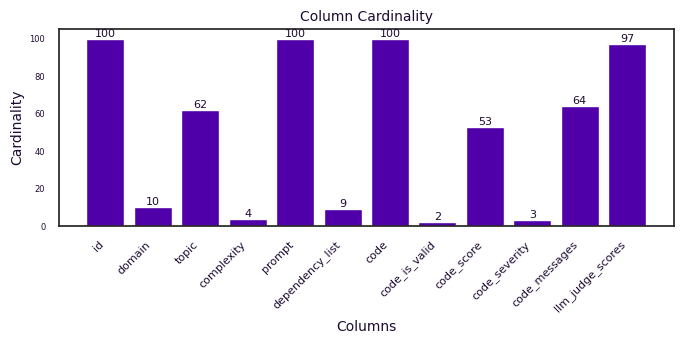

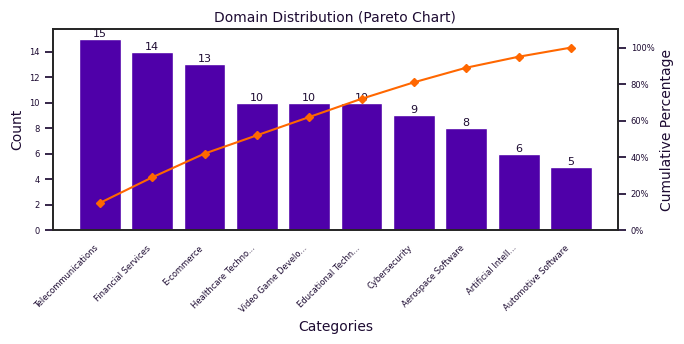

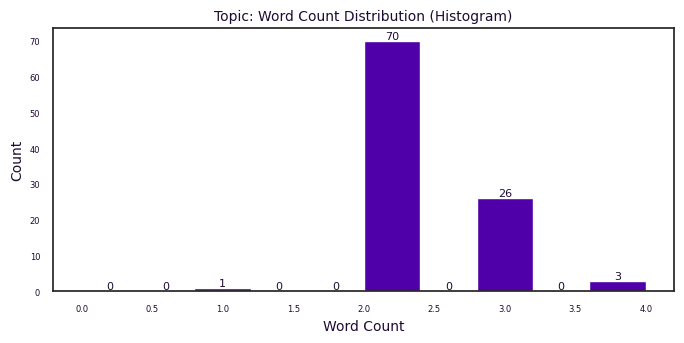

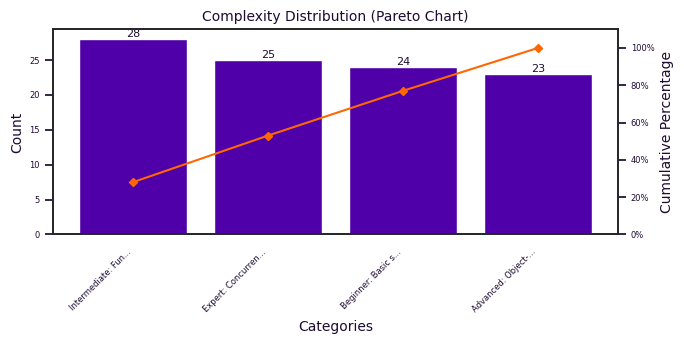

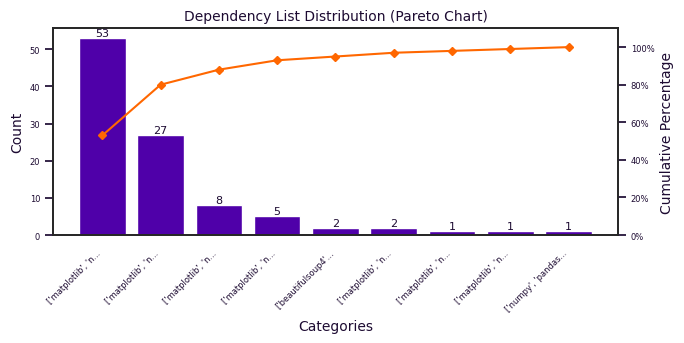

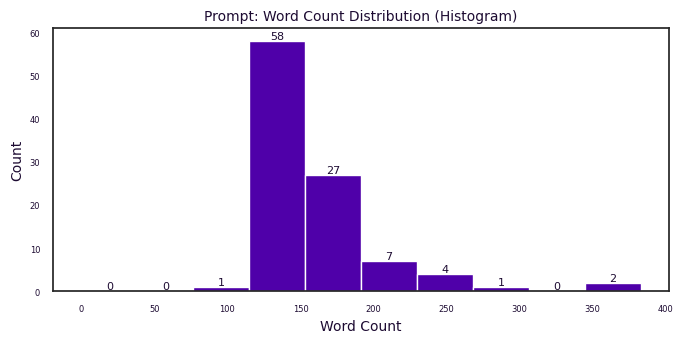

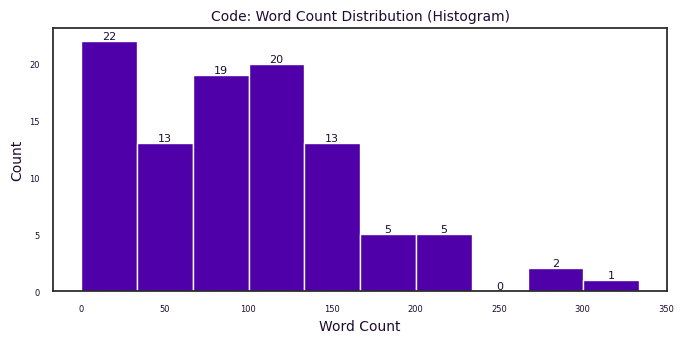

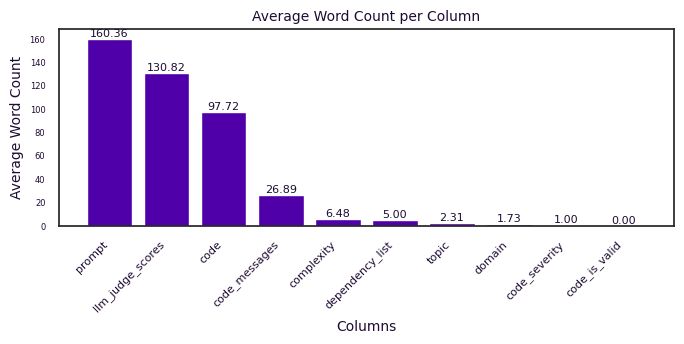

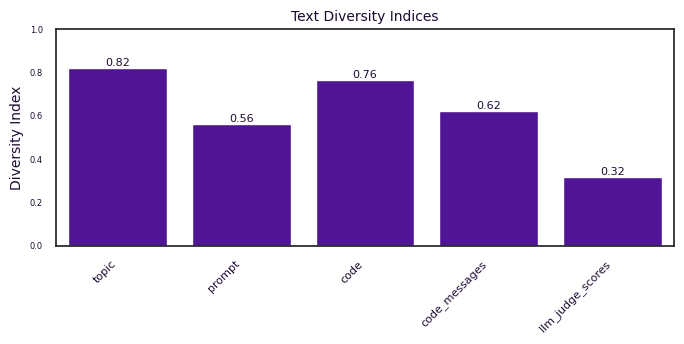

In [85]:
create_report_pdf(results, dataset_df,  'data_quality_report.pdf')

In [53]:

# field = 'Example'
# counts = [7, 7, 7, 10, 6, 6, 3, 1, 1, 2]
# bins = [0.0, 27.7, 55.4, 83.1, 110.8, 138.5, 166.2, 193.9, 221.6, 249.29999999999998, 277.0]


In [ ]:
test_str = "here's the {prompt} and here's the {response}"
test_str.format(prompt='prompt', response='response', context='context')

In [68]:
results['results']['llm_as_a_judge_mean_scores']
results['results']['valid_records_score']

{'count': 89, 'percent': 0.89}

In [88]:
results['dataset_overview_statistics']['dtypes']

{'id': 'int64',
 'domain': 'object',
 'topic': 'object',
 'complexity': 'object',
 'prompt': 'object',
 'dependency_list': 'object',
 'code': 'object',
 'code_is_valid': 'bool',
 'code_score': 'float64',
 'code_severity': 'object',
 'code_messages': 'object',
 'llm_judge_scores': 'object'}

['code', '']